In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:

# Load the dataset
data_path = 'data/AMZN.csv'
df = pd.read_csv(data_path)

# Parse the 'Date' column and add it as a feature
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['Date'] = df['Date'].map(lambda x: x.toordinal())  # Convert Date to numerical format

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(df.drop(columns=['Close', 'Adjusted Close']))  # Drop targets for scaling

# Scale the target columns 'Adjusted Close' and 'Close'
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = target_scaler.fit_transform(df[['Close']])
scaled_adj_close = target_scaler.fit_transform(df[['Adjusted Close']])

# Combine scaled targets into a single target array
scaled_targets = np.hstack((scaled_close, scaled_adj_close))  # Combined target array for multitarget prediction

In [3]:
# Define a function to create sequences for features and targets
def create_sequences_multivariate(data, targets, lookback):
    feature_sequences = []
    target_sequences = []
    for i in range(lookback, len(data)):
        feature_sequences.append(data[i - lookback:i, :])  # Feature sequences
        target_sequences.append(targets[i, :])  # Corresponding target values
    return np.array(feature_sequences), np.array(target_sequences)

# Set lookback window size
lookback = 50

# Create sequences for features and targets
X, y = create_sequences_multivariate(scaled_features, scaled_targets, lookback)

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Print data shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (4471, 50, 5), y_train shape: (4471, 2)
X_val shape: (958, 50, 5), y_val shape: (958, 2)
X_test shape: (959, 50, 5), y_test shape: (959, 2)


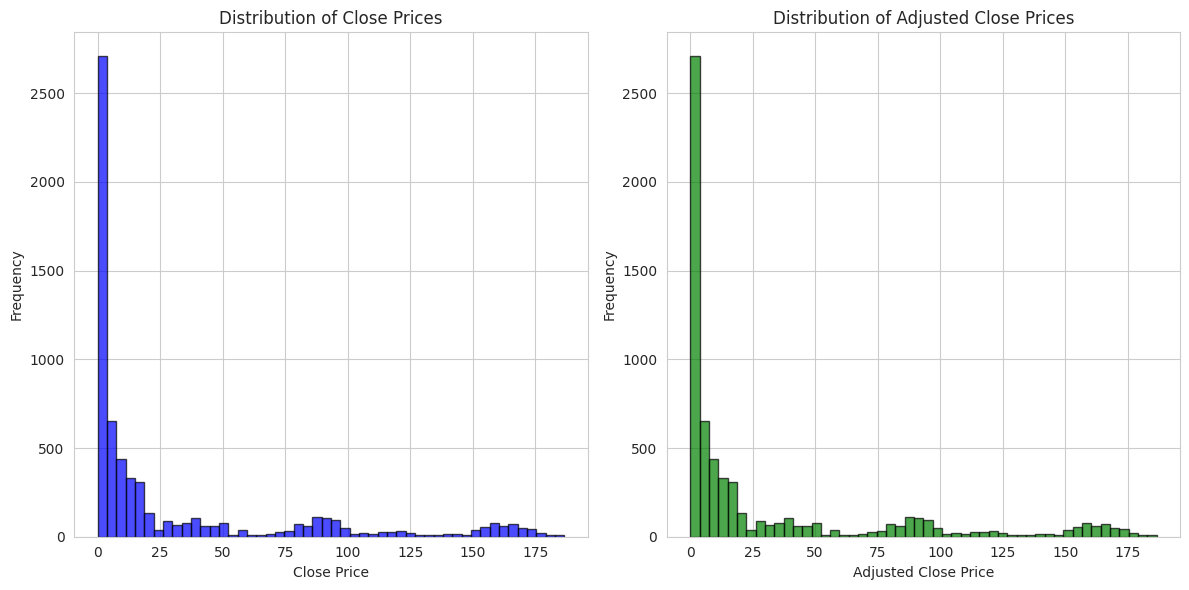

In [4]:
import matplotlib.pyplot as plt

# Load the dataset again to use original unscaled values for plotting
data_path = 'data/AMZN.csv'
df = pd.read_csv(data_path)

# Parse the 'Date' column for chronological plotting
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Plot distributions for 'Close' and 'Adjusted Close'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df['Close'], bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of Close Prices')
plt.xlabel('Close Price')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['Adjusted Close'], bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title('Distribution of Adjusted Close Prices')
plt.xlabel('Adjusted Close Price')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0319 - val_mse: 0.0319
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5977e-05 - mse: 4.5977e-05 - val_loss: 0.0245 - val_mse: 0.0245
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1092e-05 - mse: 2.1092e-05 - val_loss: 0.0227 - val_mse: 0.0227
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4350e-05 - mse: 1.4350e-05 - val_loss: 0.0209 - val_mse: 0.0209
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0549e-05 - mse: 1.0549e-05 - val_loss: 0.0188 - val_mse: 0.0188
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1186e-06 - mse: 9.1186e-06 - val_loss: 0.0174 - val_mse: 0.0174
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1045e-06 - mse: 7.1045e-06 - val_loss: 0.0163 - val_mse: 0.0163
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5308e-06 - mse: 5.5308e-06 - val_loss: 0.0152 - val_mse: 0.0152


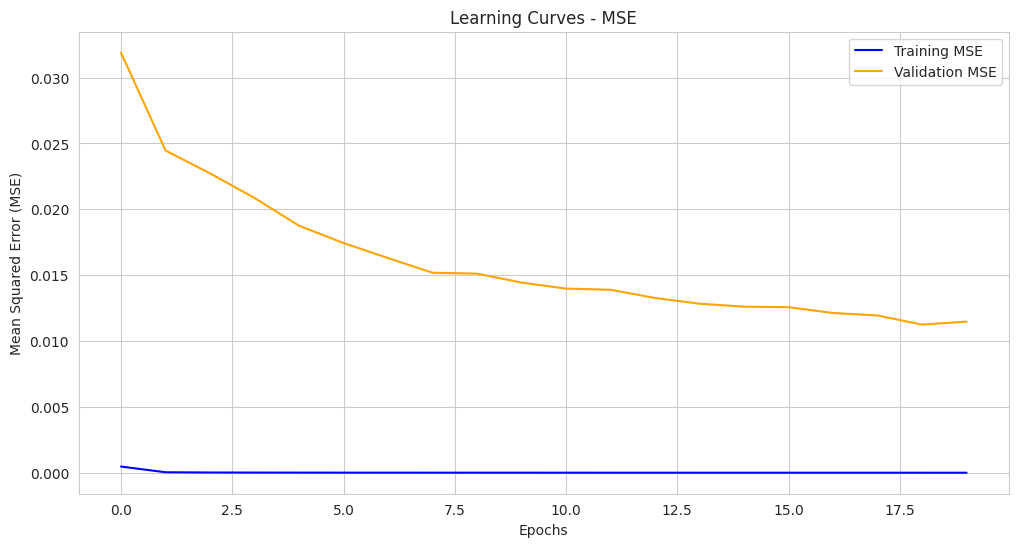

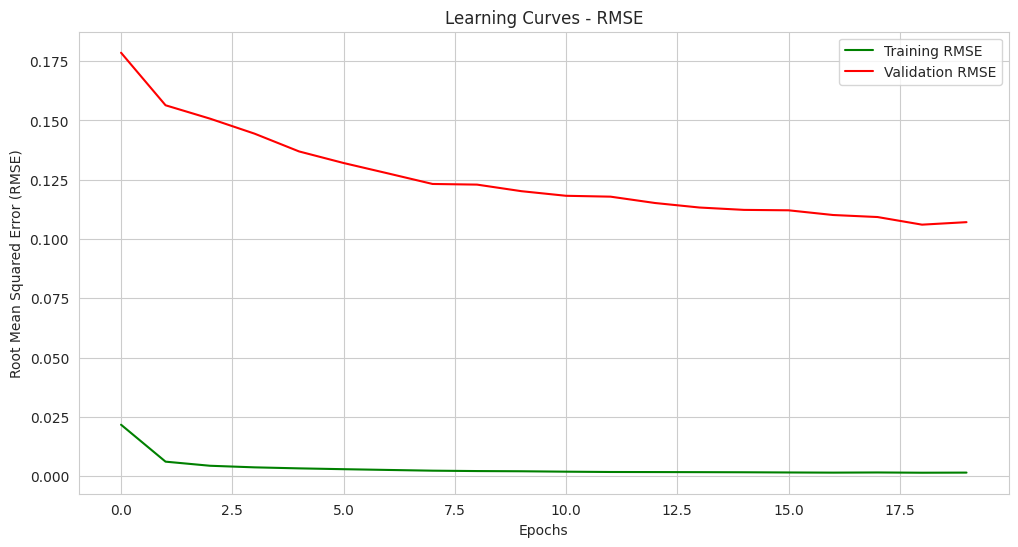

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Define the baseline SimpleRNN model
baseline_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    SimpleRNN(32, activation='relu'),  # Simple RNN layer with 32 units
    Dense(2)  # Output layer for predicting both 'Close' and 'Adjusted Close'
])

# Compile the model with RMSE (via a custom metric)
baseline_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# Train the model
history = baseline_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Evaluate the model on the test set
test_predictions = baseline_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, test_predictions))
mse_test = mean_squared_error(y_test, test_predictions)

# Plot learning curves for MSE
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training MSE', color='blue')
plt.plot(history.history['val_loss'], label='Validation MSE', color='orange')
plt.title('Learning Curves - MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Plot learning curves for MAE if available
if 'mse' in history.history:
    plt.figure(figsize=(12, 6))
    plt.plot(np.sqrt(history.history['mse']), label='Training RMSE', color='green')
    plt.plot(np.sqrt(history.history['val_mse']), label='Validation RMSE', color='red')
    plt.title('Learning Curves - RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('Root Mean Squared Error (RMSE)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [7]:

print(f"Test RMSE: {rmse_test}")
print(f"Test MSE: {mse_test}")


Test RMSE: 0.3408447919786847
Test MSE: 0.11617517221899287


In [11]:
# Rescale the predictions and targets back to their original scale for the baseline model
y_test_unscaled_baseline = target_scaler.inverse_transform(y_test)  # Unscaled actual values for baseline
test_predictions_unscaled_baseline = target_scaler.inverse_transform(test_predictions)  # Unscaled predictions for baseline

# Compare scaled values for baseline
comparison_scaled_baseline = np.hstack((y_test[:5], test_predictions[:5]))  # First 5 examples for simplicity
comparison_scaled_baseline_df = pd.DataFrame(
    comparison_scaled_baseline,
    columns=['Actual Close (scaled)', 'Actual Adj Close (scaled)', 'Pred Close (scaled)', 'Pred Adj Close (scaled)']
)

# Compare unscaled values for baseline
comparison_unscaled_baseline = np.hstack((y_test_unscaled_baseline[:5], test_predictions_unscaled_baseline[:5]))  # First 5 examples
comparison_unscaled_baseline_df = pd.DataFrame(
    comparison_unscaled_baseline,
    columns=['Actual Close (unscaled)', 'Actual Adj Close (unscaled)', 'Pred Close (unscaled)', 'Pred Adj Close (unscaled)']
)
comparison_unscaled_baseline_df


,Actual Close (unscaled),Actual Adj Close (unscaled),Pred Close (unscaled),Pred Adj Close (unscaled)
0,81.650002,81.650002,68.284454,38.653046
1,81.820000,81.820000,68.994759,38.776844
2,82.054497,82.054497,68.969658,38.105808
3,81.991501,81.991501,68.617363,38.512169
4,83.586502,83.586502,68.794670,38.803261


Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.1410e-04 - mse: 8.1410e-04 - val_loss: 2.5980e-04 - val_mse: 2.5980e-04
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3671e-06 - mse: 6.3671e-06 - val_loss: 2.0150e-04 - val_mse: 2.0150e-04
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.8938e-06 - mse: 4.8938e-06 - val_loss: 3.4163e-04 - val_mse: 3.4163e-04
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7817e-06 - mse: 4.7817e-06 - val_loss: 4.6606e-04 - val_mse: 4.6606e-04
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5291e-06 - mse: 4.5291e-06 - val_loss: 4.9499e-04 - val_mse: 4.9499e-04
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7409e-06 - mse: 4.7409e-06 - val_loss: 4.7100e-04 - val_mse: 4.7100e-04
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7721e-06 - mse: 3.7721e-06 - val_loss: 4.4264e-04 - val_mse: 4.4264e-04
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.

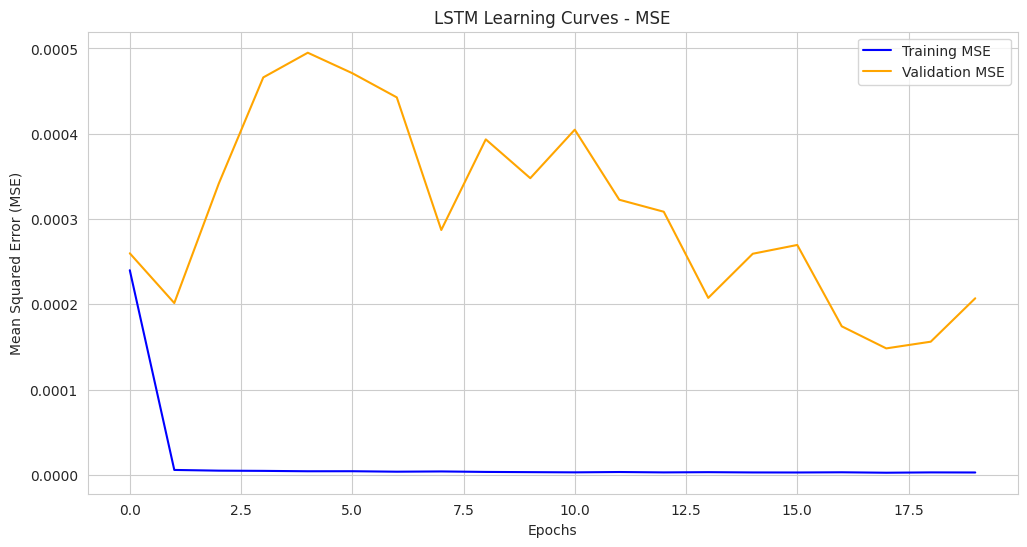

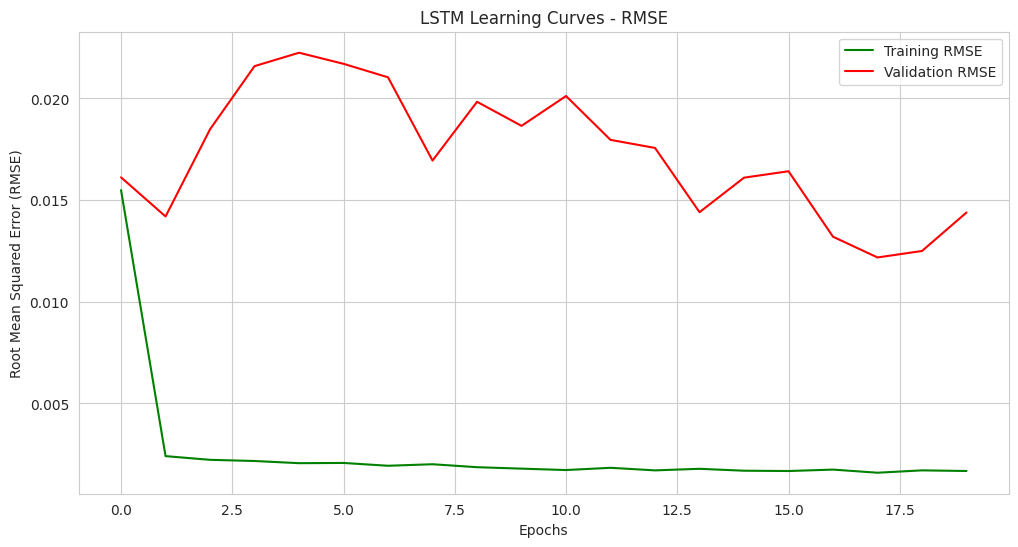

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Define the LSTM model
lstm_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, activation='tanh', return_sequences=False),  # LSTM layer with 64 units
    Dense(2)  # Output layer for predicting both 'Close' and 'Adjusted Close'
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# Train the model
history_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Evaluate the model on the test set
test_predictions_lstm = lstm_model.predict(X_test)
rmse_test_lstm = np.sqrt(mean_squared_error(y_test, test_predictions_lstm))
mse_test_lstm = mean_squared_error(y_test, test_predictions_lstm)

# Plot learning curves for MSE
plt.figure(figsize=(12, 6))
plt.plot(history_lstm.history['loss'], label='Training MSE', color='blue')
plt.plot(history_lstm.history['val_loss'], label='Validation MSE', color='orange')
plt.title('LSTM Learning Curves - MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Plot learning curves for RMSE
if 'mse' in history_lstm.history:
    plt.figure(figsize=(12, 6))
    plt.plot(np.sqrt(history_lstm.history['mse']), label='Training RMSE', color='green')
    plt.plot(np.sqrt(history_lstm.history['val_mse']), label='Validation RMSE', color='red')
    plt.title('LSTM Learning Curves - RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('Root Mean Squared Error (RMSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:

print(f"LSTM Test RMSE: {rmse_test_lstm}")
print(f"LSTM Test MSE: {mse_test_lstm}")


LSTM Test RMSE: 0.0697313832274932
LSTM Test MSE: 0.00486246580681952


In [10]:
# Rescale the predictions and targets back to their original scale for comparison
y_test_unscaled = target_scaler.inverse_transform(y_test)  # Unscaled actual values
test_predictions_unscaled = target_scaler.inverse_transform(test_predictions_lstm)  # Unscaled predictions

# Compare scaled values
comparison_scaled = np.hstack((y_test[:5], test_predictions_lstm[:5]))  # First 5 examples for simplicity
comparison_scaled_df = pd.DataFrame(
    comparison_scaled,
    columns=['Actual Close (scaled)', 'Actual Adj Close (scaled)', 'Pred Close (scaled)', 'Pred Adj Close (scaled)']
)

# Compare unscaled values
comparison_unscaled = np.hstack((y_test_unscaled[:5], test_predictions_unscaled[:5]))  # First 5 examples
comparison_unscaled_df = pd.DataFrame(
    comparison_unscaled,
    columns=['Actual Close (unscaled)', 'Actual Adj Close (unscaled)', 'Pred Close (unscaled)', 'Pred Adj Close (unscaled)']
)

comparison_unscaled_df

,Actual Close (unscaled),Actual Adj Close (unscaled),Pred Close (unscaled),Pred Adj Close (unscaled)
0,81.650002,81.650002,78.161438,77.419380
1,81.820000,81.820000,78.522324,77.650017
2,82.054497,82.054497,78.520882,77.720352
3,81.991501,81.991501,78.540535,77.763855
4,83.586502,83.586502,78.752365,77.945839


Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.5971e-06 - mse: 2.5971e-06 - val_loss: 1.7970e-04 - val_mse: 1.7970e-04
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8688e-06 - mse: 1.8688e-06 - val_loss: 1.8848e-04 - val_mse: 1.8848e-04
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.8794e-06 - mse: 1.8794e-06 - val_loss: 1.6104e-04 - val_mse: 1.6104e-04
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8096e-06 - mse: 1.8096e-06 - val_loss: 1.9112e-04 - val_mse: 1.9112e-04
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9809e-06 - mse: 1.9809e-06 - val_loss: 1.7677e-04 - val_mse: 1.7677e-04
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1943e-06 - mse: 2.1943e-06 - val_loss: 1.4389e-04 - val_mse: 1.4389e-04
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7205e-06 - mse: 1.7205e-06 - val_loss: 1.5667e-04 - val_mse: 1.5667e-04
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.

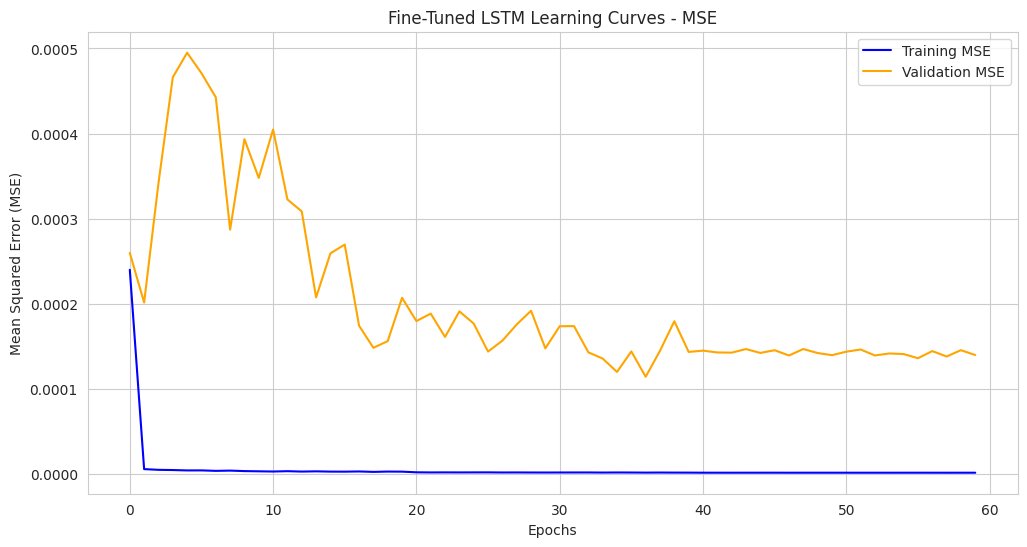

In [12]:
from tensorflow.keras.optimizers import Adam

# Reduce the learning rate to 1/10th of the original
new_optimizer_1 = Adam(learning_rate=0.0001)  # Assuming the original learning rate was 0.001
lstm_model.compile(optimizer=new_optimizer_1, loss='mse', metrics=['mse'])

# Continue training for another 20 epochs with reduced learning rate
history_lstm_fine_tune_1 = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Further reduce the learning rate to 1/100th of the original
new_optimizer_2 = Adam(learning_rate=0.00001)  # Assuming the original learning rate was 0.001
lstm_model.compile(optimizer=new_optimizer_2, loss='mse', metrics=['mse'])

# Continue training for another 20 epochs with the further reduced learning rate
history_lstm_fine_tune_2 = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Combine the training history for all phases
history_lstm_combined = {
    'loss': history_lstm.history['loss'] + history_lstm_fine_tune_1.history['loss'] + history_lstm_fine_tune_2.history['loss'],
    'val_loss': history_lstm.history['val_loss'] + history_lstm_fine_tune_1.history['val_loss'] + history_lstm_fine_tune_2.history['val_loss']
}

# Plot combined learning curves for MSE
plt.figure(figsize=(12, 6))
plt.plot(history_lstm_combined['loss'], label='Training MSE', color='blue')
plt.plot(history_lstm_combined['val_loss'], label='Validation MSE', color='orange')
plt.title('Fine-Tuned LSTM Learning Curves - MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Final Validation RMSE: 0.011825455713338097
Final Validation MSE: 0.00013984140282812064


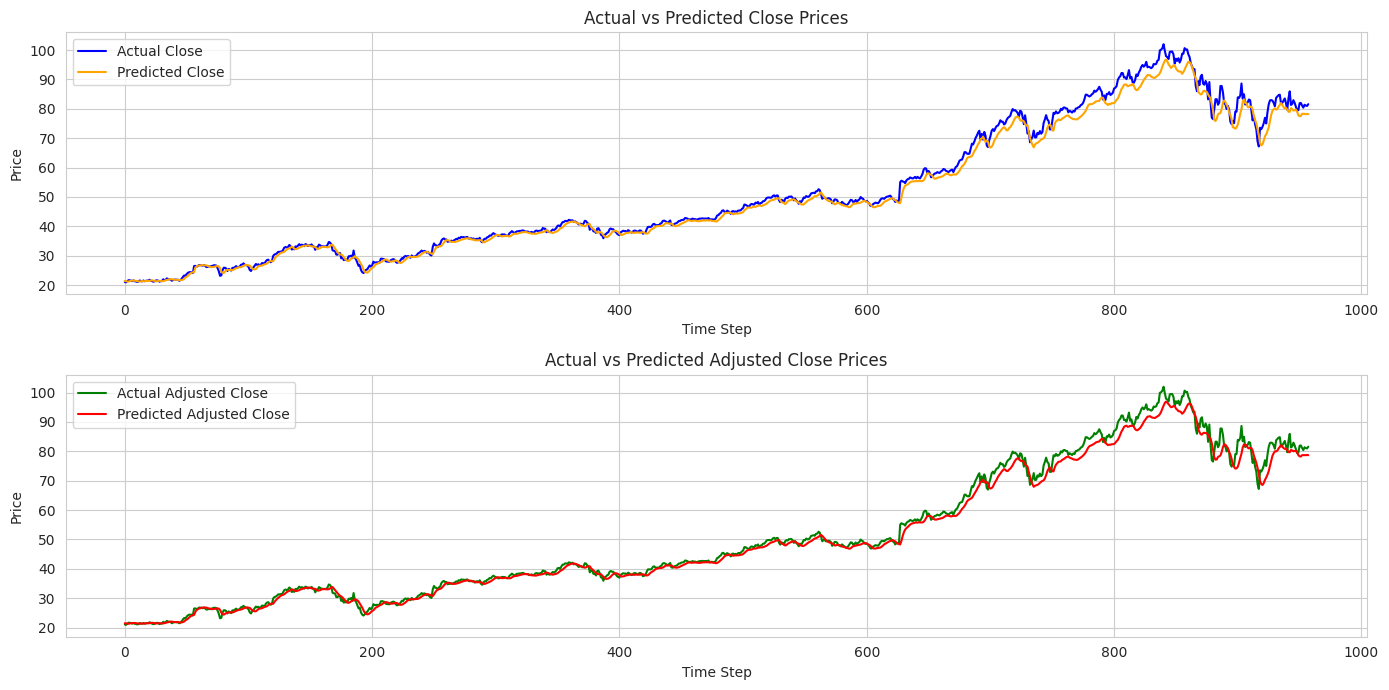

In [13]:
# Evaluate the final tuned LSTM model on the validation set
val_predictions = lstm_model.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, val_predictions))
mse_val = mean_squared_error(y_val, val_predictions)

# Display validation scores
print(f"Final Validation RMSE: {rmse_val}")
print(f"Final Validation MSE: {mse_val}")

# Rescale validation predictions and actual values for plotting
y_val_unscaled = target_scaler.inverse_transform(y_val)
val_predictions_unscaled = target_scaler.inverse_transform(val_predictions)

# Plot real vs. predicted values for both columns
plt.figure(figsize=(14, 7))

# Plot for 'Close'
plt.subplot(2, 1, 1)
plt.plot(y_val_unscaled[:, 0], label='Actual Close', color='blue')
plt.plot(val_predictions_unscaled[:, 0], label='Predicted Close', color='orange')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Plot for 'Adjusted Close'
plt.subplot(2, 1, 2)
plt.plot(y_val_unscaled[:, 1], label='Actual Adjusted Close', color='green')
plt.plot(val_predictions_unscaled[:, 1], label='Predicted Adjusted Close', color='red')
plt.title('Actual vs Predicted Adjusted Close Prices')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [14]:
import pandas as pd

# Assuming the test scores from the tuned LSTM model (replace with actual values if running locally)
test_rmse = rmse_test_lstm  # Replace with actual RMSE for the test set
test_mse = mse_test_lstm  # Replace with actual MSE for the test set

# Create a DataFrame for displaying the scores
test_scores_df = pd.DataFrame({
    'Metric': ['Root Mean Squared Error (RMSE)', 'Mean Squared Error (MSE)'],
    'Score': [test_rmse, test_mse]
})
test_scores_df

,Metric,Score
0,Root Mean Squared Error (RMSE),0.069731
1,Mean Squared Error (MSE),0.004862
